In [6]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/people/yin/anaconda3/envs/pyannote_35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
import numpy as np
from pyannote.core import Annotation,Segment, Timeline
from pyannote.core import SlidingWindowFeature

In [1]:
import clustering

## Low-latency speaker spotting (LLSS)

#### Precompute embeddings

In [2]:
from pyannote.audio.keras_utils import load_model
from pyannote.audio.features import YaafeMFCC
from pyannote.audio.embedding.extraction import SequenceEmbedding

PRETRAINED_TRISTOUNET = '/people/yin/projects/pyannote-audio/tutorials/speaker-embedding/2+0.5/TristouNet/train/Etape.SpeakerDiarization.TV.train/weights/0986.h5'
model = load_model(PRETRAINED_TRISTOUNET)

feature_extraction = YaafeMFCC(duration=0.032, step=0.020, sample_rate=16000,
                               coefs=11, D=True, DD=True,
                               e=False, De=True, DDe=True)

duration, step = 2, 1
sequence_embedding = SequenceEmbedding(model, feature_extraction, 
                                       duration, step=step)


Using Theano backend.


In [3]:
from itertools import chain
from pyannote.database import get_protocol, get_unique_identifier
from pyannote.audio.embedding.extraction import SequenceEmbedding
from pyannote.database import FileFinder

protocol = get_protocol('Etape.SpeakerDiarization.TV', preprocessors={'audio': FileFinder()}, progress=True)
embeddings = {}
for current_file in chain(protocol.train(), protocol.development(), protocol.test()):
    embeddings[get_unique_identifier(current_file)] = sequence_embedding.apply(current_file)

Training set: 28it [01:04,  1.41s/it]
Development set: 9it [00:20,  1.96s/it]
Test set: 9it [00:19,  1.90s/it]


#### LLSS system 3

Oracle online diarization

In [21]:
def system3(embedding, model, oracle_diarization=None):
    onlineOracleClustering = clustering.OnlineOracleClustering('test')
    start = embedding.sliding_window[0].start
    data = np.zeros((len(embedding.data), 1))
    for i, (window, _) in enumerate(embedding):
        so_far = Segment(start, window.end)
        current_annotation = oracle_diarization.crop(so_far)
        score = 0.
        for segment, _, label in current_annotation.itertracks(label=True):
            #print(label, segment)
            example = {}
            example['label'] = label
            example['segment'] = segment
            example['embedding'] = embedding.crop(segment)
            onlineOracleClustering.upadateCluster(example)
        if not onlineOracleClustering.empty():
            min_dist = min(onlineOracleClustering.computeDistances({'embedding': model}))
            score = max(score, 2-min_dist)
        data[i] = score
        start = window.end
    return SlidingWindowFeature(data, embedding.sliding_window)

In [28]:
def system4(embedding, models, oracle_diarization=None):
    onlineOracleClustering = clustering.OnlineOracleClustering('test')
    start = embedding.sliding_window[0].start
    res = {}
    scores = {}
    for label, _ in models.items():
        res[label] =  np.zeros((len(embedding.data), 1))
        scores[label] = 0
    
    
    for i, (window, _) in enumerate(embedding):
        so_far = Segment(start, window.end)
        current_annotation = oracle_diarization.crop(so_far)
        score = 0.
        for segment, _, label in current_annotation.itertracks(label=True):
            #print(label, segment)
            example = {}
            example['label'] = label
            example['segment'] = segment
            example['embedding'] = embedding.crop(segment)
            onlineOracleClustering.upadateCluster(example)
        if not onlineOracleClustering.empty():
            min_dists = onlineOracleClustering.modelsDistances( models)
            for label, _ in models.items():
                scores[label] = max(scores[label], 2-min_dists[label])
        for label, _ in models.items():
            res[label][i] = scores[label]
        start = window.end
    for label, _ in models.items():
        res[label] = SlidingWindowFeature(res[label], embedding.sliding_window)
    return res

In [10]:
from pyannote.audio.embedding.utils import l2_normalize
models = {}
for current_file in protocol.train():
    annotation = current_file['annotation']
    embedding = embeddings[get_unique_identifier(current_file)]
    for label in annotation.labels():
        if label in models:
            continue
        models[label] = l2_normalize(np.sum(embedding.crop(annotation.label_timeline(label)), axis=0, keepdims=True))

Training set: 28it [00:00, 83.89it/s]


In [18]:
system = system3

In [20]:
from pyannote.metrics.spotting import LowLatencySpeakerSpotting
metric = LowLatencySpeakerSpotting(thresholds=np.linspace(0, 2, 50))

# for each file in development set
for current_file in protocol.development():
    annotation = current_file['annotation']
    embedding = embeddings[get_unique_identifier(current_file)]
    # for each model from enrollment
    for label, model in models.items():
        # compute score stream wrt. to this model
        scores = system(embedding, model, annotation)
        # evaluate this trial
        reference = annotation.subset([label])
        metric(reference, scores)
    break


Development set: 0it [00:00, ?it/s]


Gérard_Menuel
Bernard_Deflesselles
<unknown>
BFMTV_BFMStory_2011-01-03_175900_speaker#8
Jacques_Myard
Xavier_Bertrand
Francis_Szpiner
LCP_CaVousRegarde_2010-09-28_204900_speaker#4
Dominique_Paillé
Virginie_Goubier
Philippe_Vasset
Michel_Sapin
Luc_Abratkiewicz
BFMTV_BFMStory_2010-10-01_175900_speaker#1
Bruno_Julliard
BFMTV_BFMStory_2011-01-03_175900_speaker#3
BFMTV_BFMStory_2010-10-01_175900_speaker#14
BFMTV_BFMStory_2010-10-01_175900_speaker#17
BFMTV_BFMStory_2011-01-03_175900_speaker#1
Olivier_Metzner
Philippe_Salvador
Carl_Meeus
Audrey-Sophie_Nacass
Christophe_Caresche
Anaïs_Goubatian
Pascal_Schmitt
Rachid_M'Barki
Laurence_Ferrari
BFMTV_BFMStory_2010-09-14_175900_speaker#1
Christian_Prouteau
Patrick_Mennucci
Julia_Le_Correc
Jean-Pierre_Decool
Elisabeth_Guigou
Marisol_Touraine
Martine_Baudin
Graziella_Rodrigues
Olivier_Truchot
Eric_Ciotti
BFMTV_BFMStory_2010-10-01_175900_speaker#3
Pierre-Yves_Bournazel
Christine_Lagarde
Julia_Delage
Aurélie_Filippetti
Michèle_Alliot-Marie
Candice_Maho

In [23]:
system = system4

In [30]:
metric = LowLatencySpeakerSpotting(thresholds=np.linspace(0, 2, 50))

# for each file in development set
for current_file in protocol.development():
    annotation = current_file['annotation']
    embedding = embeddings[get_unique_identifier(current_file)]
    # for each model from enrollment
    scores = system4(embedding, models, oracle_diarization=annotation)
    for label, _ in models.items():
        # compute score stream wrt. to this model
        score = scores[label]
        # evaluate this trial
        reference = annotation.subset([label])
        metric(reference, score)


Development set: 0it [00:00, ?it/s]
Development set: 9it [15:36, 67.46s/it] 


### DET curve

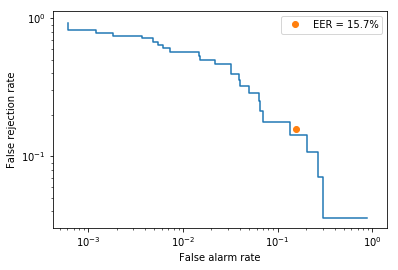

In [38]:
thresholds, fpr, fnr, eer, cdet = metric.det_curve()
loglog(fpr, fnr); xlabel('False alarm rate'); ylabel('False rejection rate');
plot([eer,], [eer,], 'o', label='EER = {0:.1f}%'.format(100*eer))
legend()

### $C_{det}$ cost as a function of the detection threshold

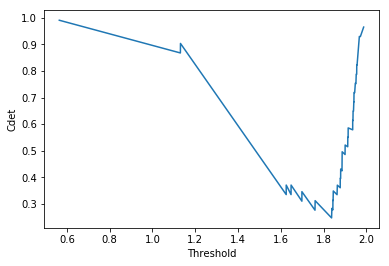

In [43]:
plot(thresholds, cdet, label='Cdet'); xlabel('Threshold'); ylabel('Cdet');